In [1]:
import sys
import pickle
sys.path.insert(0,'./')
import pyccl as ccl
import tracemalloc
from jk_utils import *

# from importlib import reload

In [2]:
import dask
from distributed import LocalCluster
from dask.distributed import Client  # we already had this above
#http://distributed.readthedocs.io/en/latest/_modules/distributed/worker.html
LC=LocalCluster(n_workers=10,processes=False,memory_limit='50gb',threads_per_worker=1,memory_spill_fraction=.99,)
#                memory_monitor_interval='2000ms',worker_memory_limit='50gb')
client=Client(LC)
# dask.config.set(scheduler='single-threaded')

/usr/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [3]:
client

Client Scheduler: inproc://136.152.250.206/4815/1 Dashboard: http://localhost:8787/status,Cluster Workers: 10 Cores: 10 Memory: 500.00 GB


In [4]:
client.restart()

Client Scheduler: inproc://136.152.250.206/4815/1 Dashboard: http://localhost:8787/status,Cluster Workers: 10 Cores: 10 Memory: 500.00 GB


In [5]:
from cov_3X2 import *
# from fisher import *

In [6]:
#only for python3
import importlib
reload=importlib.reload

# Lensing X Lensing Correlation function covariance

## Multiple redshift bins (Tomography)

In [7]:
from lsst_utils import *

In [8]:
import cov_utils
reload(cov_utils)
from cov_utils import *

In [9]:
import window_utils
reload(window_utils)
from window_utils import *

In [10]:
import cov_3X2
reload(cov_3X2)
from cov_3X2 import *
from wigner_transform import *

In [11]:
import hankel_transform
from astropy.io import fits
reload(hankel_transform)
from hankel_transform import *


In [12]:
cosmo_params={'h': 0.8433,
 'Omb': 0.062,
 'Omd': 0.2837-0.062,
 's8': 0.795431,
 'Om': 0.2837,
 'As': 1.685e-09,
 'Ase9': 1.685,
 'mnu': 0.0,
 'Omk': 0.0,
 'tau': 0.06,
 'ns': 0.96859,
 'w': -1,
 'wa': 0,
 'Oml': 1.-0.2837}
PS=Power_Spectra(cosmo_params=cosmo_params)
k,pk,s8=PS.camb_pk(z=[0],cosmo_params=cosmo_params,return_s8=True)
s8

0.7971166457654738

In [13]:
mnu=cosmo_h.m_nu*0
cosmo=cosmo.clone(m_nu=mnu,Ob0=cosmo_params['Omb'],Om0=cosmo_params['Om'])
cosmo_h=cosmo.clone(H0=100) #,m_nu=mnu,Ob0=cosmo_params['Omb'],Om0=cosmo_params['Om'])
ccl_cosmo = ccl.Cosmology(Omega_c=cosmo_params['Omd'], Omega_b=cosmo_params['Omb'], 
                      h=cosmo_params['h'], A_s=cosmo_params['As'], n_s=cosmo_params['ns'],)#m_nu=[0,0,0.06])

In [14]:
use_window=True
do_sample_variance=True
SSV_cov=False
tidal_SSV=True
Tri_cov=False
sigma_gamma=0.3944/sqrt(2.)  #*2**0.25

In [15]:
f_sky=.3 #3000./(4*np.pi/d2r**2)
f_sky

nside=512

In [16]:
f_sky

0.3

In [68]:
zmin=0.3
zmax=2

z=np.linspace(0,5,200)
pzs=lsst_pz_source(z=z)
x=z<zmax
x*=z>zmin
z=z[x]
pzs=pzs[x]

ns0=26 #26+np.inf #ns=inf means shape noise is zero
nbins=1  # Number of tomographic bins
z_sigma=0.03
zs_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,use_window=use_window,f_sky=f_sky,window_cl_fact=1,
                         ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),sigma_gamma=sigma_gamma,
                        zp_sigma=z_sigma*np.ones_like(z),nside=nside,)

ng0=10 #26+np.inf #ns=inf means shape noise is zero
nlbins=1 # Number of tomographic bins
z_sigma=0.005
zl_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ng0,nz_bins=nlbins,use_window=use_window,f_sky=f_sky,
                         ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_likxe(z),window_cl_fact=1,
                        zp_sigma=z_sigma*np.ones_like(z),k_max=1.e6,nside=nside,)
for i in np.arange(nlbins):
    zl_bins[i]['b1']=1

corr_indxs {('shear', 'shear'): [], ('galaxy', 'galaxy'): [(0, 0)], ('kappa', 'kappa'): []}
Win gen: step size 1536
cl dict done
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


AttributeError: module 'numpy' has no attribute 'zeros_likxe'

In [ ]:
for a in ()+("X",):
    print (a)

In [ ]:
do_cov=True

In [ ]:
do_xi=True
bin_xi=True
bin_cl=True
th_min=2.5/60
th_max=250./60
n_th_bins=20
th_bins=np.logspace(np.log10(th_min),np.log10(th_max),n_th_bins+1)
th=np.logspace(np.log10(th_min*0.98),np.log10(1),n_th_bins*30)
th2=np.linspace(1,th_max*1.02,n_th_bins*30)
# th2=np.logspace(np.log10(1),np.log10(th_max),60*6)
th=np.unique(np.sort(np.append(th,th2)))
thb=np.sqrt(th_bins[1:]*th_bins[:-1])

In [ ]:
#Hankel Transform setup
l_max=1e3
l_maxW=1e3
l_min=0
# nl=1e2
# nl_bins=np.int(nl/10)
# l0=np.logspace(np.log10(l_min),np.log10(l_maxW),nl)
# l0=np.append([0,1],l0)
# l0=np.unique(np.int32(l0))
# l0_HT=l0
l0=np.arange(l_min,l_max)
l0_HT=np.arange(l_max)
nl_bins=20
  #np.arange(l_min,l_max)
# l0=np.unique(np.int32(np.logspace(np.log10(l_min),np.log10(l_maxW),4.e3)))   #np.arange(l_min,l_max)
# l_bins=np.unique(np.int32(np.logspace(np.log10(l_min),np.log10(l_max),50)))
l_bins=np.unique(np.int32(np.linspace(l_min,l_max,nl_bins)))
lb=0.5*(l_bins[1:]+l_bins[:-1])
prune_theta=0
HT_kwargs={'l_min':l_min,  'l_max':l_max,
                        'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
                        'n_zeros':40000, 'prune_theta':prune_theta, 'm1_m2':[(2,2),(2,-2),(0,2),(0,0)]}
# %time HT=hankel_transform(**HT_kwargs)
# HT_kwargs2={'l_min':l_min,  'l_max':l_max,
#                         'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
#                         'n_zeros':40000, 'prune_theta':2, 'm1_m2':[(2,-2)]}#,(2,-2)]}

In [ ]:
power_spectra_kwargs={'cosmo':cosmo,'cosmo_params':cosmo_params,'pk_func':'camb_pk_too_many_z'}

In [ ]:
corr_ggl=('shear','galaxy')
corr_ggk=('kappa','galaxy')
corr_gg=('galaxy','galaxy')
corr_ll=('shear','shear')
corr_kk=('kappa','kappa')
m1m2=(0,2)
m1m2_gg=(0,0)

In [ ]:
#### Wigner Transform setup... Using high ell to test convergence
WT_L_kwargs={'l': l0_HT,'theta': th*d2r,'m1_m2':[(2,2),(2,-2),(0,2),(2,0),(0,0)]}
%time WT_L=wigner_transform(**WT_L_kwargs)

In [ ]:
window_lmax=1000
bi=(0,0)



In [ ]:
import window_utils
reload(window_utils)
from window_utils import *

import cov_utils
reload(cov_utils)
from cov_utils import *

import cov_3X2
reload(cov_3X2)
from cov_3X2 import *

In [ ]:
do_cov=True
use_window=True

In [69]:
wigner_files={}
wigner_files[0]= 'temp/dask_wig3j_l6500_w2100_0_reorder.zarr'
wigner_files[2]= 'temp/dask_wig3j_l3500_w2100_2_reorder.zarr'

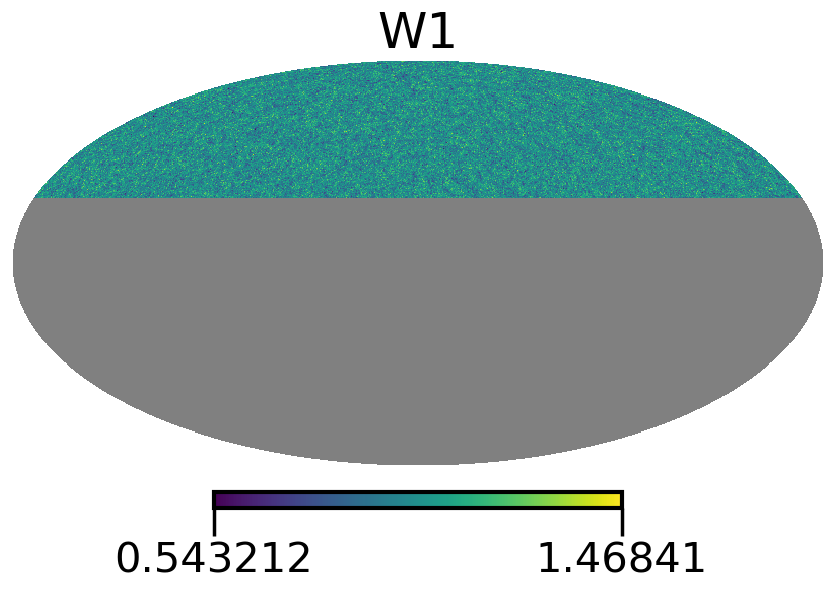

In [70]:
hp.mollview(zs_bins[0]['window'],title='W1')

In [71]:
tracemalloc.clear_traces()
tracemalloc.start()

t1=time.time()
try:
    Win=XI_W_L.Win.Win
except:
    Win=None
XI_W_L= cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,zg_bins=zl_bins,
                do_sample_variance=do_sample_variance,use_window=use_window,window_lmax=window_lmax,
                power_spectra_kwargs=power_spectra_kwargs,corrs=[corr_ll,corr_gg,corr_ggl]
                ,store_win=True,#Win=Win,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT=WT_L,f_sky=f_sky,
               bin_xi=bin_xi,theta_bins=th_bins,
               wigner_files=wigner_files)#ns=np.inf)
t2=time.time()
snapshot1 = tracemalloc.take_snapshot()
print('W done',t2-t1)
top_stats = snapshot1.statistics('lineno')

corr_indxs {('shear', 'shear'): [(0, 0)], ('galaxy', 'galaxy'): [(0, 0)], ('kappa', 'kappa'): [], ('shear', 'galaxy'): [(0, 0)], ('galaxy', 'shear'): [(0, 0)]}
Win gen: step size 624
wigner_files: {0: 'temp/dask_wig3j_l6500_w2100_0_reorder.zarr', 2: 'temp/dask_wig3j_l3500_w2100_2_reorder.zarr'}
wigner done dict_keys([0, 2])
setting windows <Client: scheduler='inproc://136.152.250.206/4815/1' processes=10 cores=10>
got window cls, now to coupling matrices.
done coupling submatrix  0 57.111480951309204 2.0413413047790527 50.59247660636902
done coupling submatrix  624 31.49967074394226 2.983832836151123 25.046177625656128
W done 122.73937439918518


In [31]:
XI_W_L_NW= cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,zg_bins=zl_bins, #no window
                do_sample_variance=do_sample_variance,use_window=False,window_lmax=window_lmax,
                power_spectra_kwargs=power_spectra_kwargs,corrs=[corr_ll,corr_ggl,corr_gg],store_win=True,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT=WT_L,f_sky=f_sky,
               bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)
print('NW done')
%time clG_nw=XI_W_L_NW.cl_tomo()

corr_indxs {('shear', 'shear'): [(0, 0)], ('galaxy', 'galaxy'): [(0, 0)], ('kappa', 'kappa'): [], ('shear', 'galaxy'): [(0, 0)], ('galaxy', 'shear'): [(0, 0)]}
Win gen: step size 624
NW done
added extra corr calc for covariance [('shear', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('galaxy', 'shear')]
Note: redshifts have been re-sorted (earliest first)
cl dict done
CPU times: user 3.39 s, sys: 9.06 ms, total: 3.4 s
Wall time: 716 ms


In [72]:
%time clG=XI_W_L.cl_tomo()
# %time cl_L=clG['stack'].compute()

added extra corr calc for covariance [('shear', 'shear'), ('galaxy', 'galaxy'), ('shear', 'galaxy'), ('galaxy', 'shear')]
Note: redshifts have been re-sorted (earliest first)
cl dict done
CPU times: user 3.42 s, sys: 25.2 ms, total: 3.45 s
Wall time: 807 ms


In [73]:
corr=corr_gg

In [74]:
cl0={'cl':{},'cl_b':{}}
cl0['cl'][corr]=clG_nw['cl'][corr][bi].compute()
cl0['cl_b'][corr]=clG_nw['cl_b'][corr][bi].compute()

cl0_win={'cl':{},'cl_b':{}}
cl0_win['cl'][corr]=clG['cl'][corr][bi].compute()
cl0_win['cl_b'][corr]=clG['cl_b'][corr][bi].compute()



In [104]:
XI_W_L.SN[corr][bi]

array([1.0427849e-08])

In [75]:
bi=(0,0)
local_state = np.random.RandomState(12312)
clg0=clG['cl'][corr][bi].compute()#[:512]
clN0=XI_W_L.SN[corr][bi]*np.ones_like(clg0)#[:256]
cl_map=hp.synfast(clg0,nside=nside,RNG=local_state)#new=True,pol=False)
N_map=hp.synfast(clN0,nside=nside,RNG=local_state)#new=True,pol=False)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


(1, 1000)

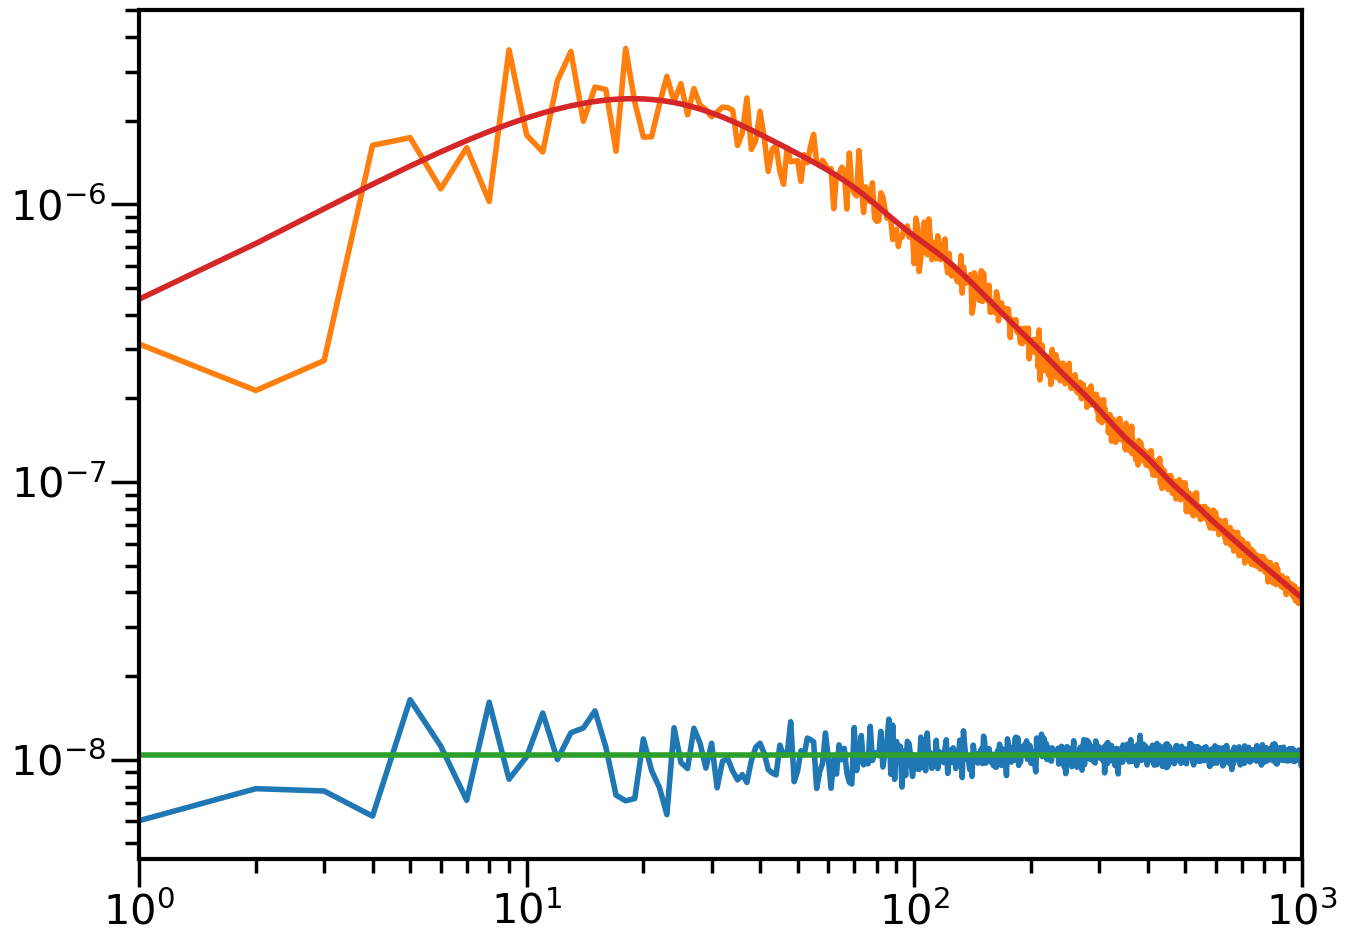

In [76]:
plot(l0,hp.anafast(N_map,lmax=np.int(l0.max())))
plot(l0,hp.anafast(cl_map,lmax=np.int(l0.max())))
plot(l0,clN0)
plot(l0,clg0)
loglog()
xlim(1,1000)

In [77]:
kappa0=XI_W_L

In [78]:
import binning
reload(binning)
from binning import *
M_binnings={}
M_binning_utils={}

for corr in [corr_gg]:
    M_binnings[corr]=binning()
    wt_b=1./cl0['cl_b'][corr]
    wt0=cl0['cl'][corr]
    M_binning_utils[corr]=M_binnings[corr].bin_utils(r=kappa0.l,r_bins=kappa0.l_bins,
                                                r_dim=2,mat_dims=[1,2],wt_b=wt_b,wt0=wt0)


In [79]:
def corr_matrix(cov_mat=[]): #correlation matrix
    diag=np.diag(cov_mat)
    return cov_mat/np.sqrt(np.outer(diag,diag))
def get_cljk(cl_map,N_map,jk_win):
    x=jk_win>-100
    print(x.mean())
    cl_map_jk=cl_map*jk_win
    N_map_jk=N_map*np.sqrt(jk_win)
    jk_map=cl_map_jk+N_map_jk
    clp=hp.anafast(jk_map,lmax=np.int(l0.max()))
    return clp
#     if ndim>1:
#         for i in np.arange(3):
#             tracer=tracers[i]
#             cl_map[i]*=window[tracer]
#             N_map[i]*=np.sqrt(window[tracer])
#             cl_map[i]+=N_map[i]
#             cl_map[i][mask[tracer]]=hp.UNSEEN
#             N_map[i][mask[tracer]]=hp.UNSEEN

#         clpi=hp.anafast(cl_map, lmax=max(l),pol=True) #TT, EE, BB, TE, EB, TB for polarized input map
#         clpi=clpi[:,l]
#         clpi_B=clpi[[2,4,5],:]
#         clpi=clpi[[0,1,3],:]



In [80]:
njk1=12
njk2=njk1
njk=njk1*njk2

mask=zs_bins[0]['window']>-1000
mask=mask.astype('bool')
jkmap=jk_map(mask=mask,nside=nside,njk1=njk1,njk2=njk2)

In [81]:
jk_corr_indxs={}
jk_corr_indxs[corr]=[(i,i) for i in np.arange(njk2)]

In [82]:
clp_jk={}
clg_jk={}
Mcl_jk={}
MN_jk={}
for i1 in np.arange(njk1):
    zs_binjk={}

    for k in zs_bins.keys():
        if k==0:
            continue
        zs_binjk[k]=zs_bins[k]

    for i2 in np.arange(njk2):
        ijk=i1*njk2+i2
        zs_binjk[i2]=copy.deepcopy(zs_bins[0])
        x=jkmap==ijk
        zs_binjk[i2]['window'][x]=hp.UNSEEN
#         zs_binjk[i2]['window']=hp.ud_grade(zs_binjk[i2]['window'],nside_out=512,pess=True,power=-2)
        zs_binjk[i2]['window_alm']=hp.map2alm(zs_binjk[i2]['window'])
        clp_jk[ijk]=get_cljk(cl_map,N_map,zs_binjk[i2]['window'])
#         zs_binjk[ijk]['window']=None
        zs_binjk[i2]['window_cl']=None
          
    kappa_win_jk= cov_3X2(zs_bins=zs_binjk,l=l0,do_cov=False,bin_cl=bin_cl,l_bins=l_bins,zg_bins=zs_binjk,
                do_sample_variance=do_sample_variance,use_window=use_window,window_lmax=window_lmax,
                power_spectra_kwargs=power_spectra_kwargs,corrs=[corr]
                ,store_win=True,#Win=Win,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT=WT_L,f_sky=f_sky,
               bin_xi=bin_xi,theta_bins=th_bins,
               wigner_files=wigner_files,
               corr_indxs=jk_corr_indxs)#ns=np.inf)
    for i2 in np.arange(njk2):
        ijk=i1*njk2+i2
        Mcl_jk[ijk]=kappa_win_jk.Win.Win['cl'][corr][bi]['M']
        MN_jk[ijk]=kappa_win_jk.Win.Win['cl'][corr][bi]['M_noise']
        clp_jk[ijk]-=clN0@MN_jk[ijk]
        clp_jk[ijk]=M_binnings[corr].bin_1d(xi=clp_jk[ijk],bin_utils=kappa0.cl_bin_utils)
        Mcl_jk[ijk]=M_binnings[corr].bin_2d_coupling(cov=Mcl_jk[ijk].T,bin_utils=M_binning_utils[corr])
        Mcl_jk[ijk]=Mcl_jk[ijk].T  #to keep the same order in dot product later. Remeber that the coupling matrix is not symmetric.
        
        clg_jk[ijk]=clp_jk[ijk]@np.linalg.inv(Mcl_jk[ijk])
    del kappa_win_jk
    del zs_binjk

0.2979167302449544


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


0.2979164123535156
0.2979164123535156
0.2979167302449544
0.2979164123535156
0.2979164123535156
0.2979167302449544
0.2979164123535156
0.2979164123535156
0.2979167302449544
0.2979164123535156
0.2979164123535156
corr_indxs {('galaxy', 'galaxy'): [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11)], ('shear', 'shear'): [(0, 0)], ('kappa', 'kappa'): [], ('shear', 'galaxy'): [(0, 0)], ('galaxy', 'shear'): [(0, 0)]}
Win gen: step size 624
wigner_files: {0: 'temp/dask_wig3j_l6500_w2100_0_reorder.zarr', 2: 'temp/dask_wig3j_l3500_w2100_2_reorder.zarr'}
wigner done dict_keys([0, 2])
setting windows <Client: scheduler='inproc://136.152.250.206/4815/1' processes=10 cores=10>
got window cls, now to coupling matrices.
done coupling submatrix  0 35.689810037612915 0.62282395362854 35.06696844100952
done coupling submatrix  624 22.31067728996277 0.6134769916534424 21.69719910621643
0.2979164123535156
0.2979164123535156
0.2979167302449544
0.297916412353515

got window cls, now to coupling matrices.
done coupling submatrix  0 37.04479455947876 0.6095716953277588 36.43522024154663
done coupling submatrix  624 23.38591432571411 0.5540471076965332 22.831864595413208
0.29792213439941406
0.29792054494222003
0.29792308807373047
0.29792308807373047
0.29792308807373047
0.29792308807373047
0.29791927337646484
0.29792213439941406
0.29792213439941406
0.29792213439941406
0.29792213439941406
0.29792213439941406
corr_indxs {('galaxy', 'galaxy'): [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11)], ('shear', 'shear'): [(0, 0)], ('kappa', 'kappa'): [], ('shear', 'galaxy'): [(0, 0)], ('galaxy', 'shear'): [(0, 0)]}
Win gen: step size 624
wigner_files: {0: 'temp/dask_wig3j_l6500_w2100_0_reorder.zarr', 2: 'temp/dask_wig3j_l3500_w2100_2_reorder.zarr'}
wigner done dict_keys([0, 2])
setting windows <Client: scheduler='inproc://136.152.250.206/4815/1' processes=10 cores=10>
got window cls, now to coupling matrices.

In [83]:
clg_sim0={}
clp_sim0={}

MN_sim0=kappa0.Win.Win['cl'][corr][bi]['M_noise']
Mcl_sim0=kappa0.Win.Win['cl'][corr][bi]['M']
Mcl_sim0=M_binnings[corr].bin_2d_coupling(cov=Mcl_sim0.T,bin_utils=M_binning_utils[corr])
Mcl_sim0=Mcl_sim0.T  #to keep the same order in dot product later. Remeber that the coupling matrix is not symmetric.
for i in np.arange(njk):
    local_state = np.random.RandomState(12312+i)
    cl_map_i=hp.synfast(clg0,nside=nside,RNG=local_state)#new=True,pol=False)
    N_map_i=hp.synfast(clN0,nside=nside,RNG=local_state)#new=True,pol=False)
    
    clp_sim0[i]=get_cljk(cl_map_i,N_map_i,zs_bins[0]['window'])
    
    clp_sim0[i]-=clN0@MN_sim0
    clp_sim0[i]=M_binnings[corr].bin_1d(xi=clp_sim0[i],bin_utils=kappa0.cl_bin_utils)
    clg_sim0[i]=clp_sim0[i]@np.linalg.inv(Mcl_sim0)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
0.2999998728434245


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
0.2999998728434245
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
0.2999998728434245
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
0.2999998728434245
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
0.2999998728434245
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
0.2999998728434245
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
0.2999998728434245
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Si

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
0.2999998728434245
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
0.2999998728434245
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
0.2999998728434245
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
0.2999998728434245
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
0.2999998728434245
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
0.2999998728434245
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Si

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
0.2999998728434245
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
0.2999998728434245
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
0.2999998728434245
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
0.2999998728434245
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
0.2999998728434245
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
0.2999998728434245
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Si

In [84]:
vv=np.array(list(clp_jk.values()))
clp_jk_mean=np.mean(vv,axis=0)
clp_jk_cov=np.cov(vv,rowvar=0)*(njk-1)
clp_jk_std=np.sqrt(np.diag(clp_jk_cov))

In [85]:
vv=np.array(list(clg_jk.values()))
clg_jk_mean=np.mean(vv,axis=0)
clg_jk_cov=np.cov(vv,rowvar=0)*(njk-1)
clg_jk_std=np.sqrt(np.diag(clg_jk_cov))

In [86]:
vv0=np.array(list(clg_sim0.values()))
clg_sim0_mean=np.mean(vv0,axis=0)
clg_sim0_cov=np.cov(vv0,rowvar=0)
clg_sim0_std=np.sqrt(np.diag(clg_sim0_cov))

In [87]:
vv0=np.array(list(clp_sim0.values()))
clp_sim0_mean=np.mean(vv0,axis=0)
clp_sim0_cov=np.cov(vv0,rowvar=0)
clp_sim0_std=np.sqrt(np.diag(clp_sim0_cov))

[]

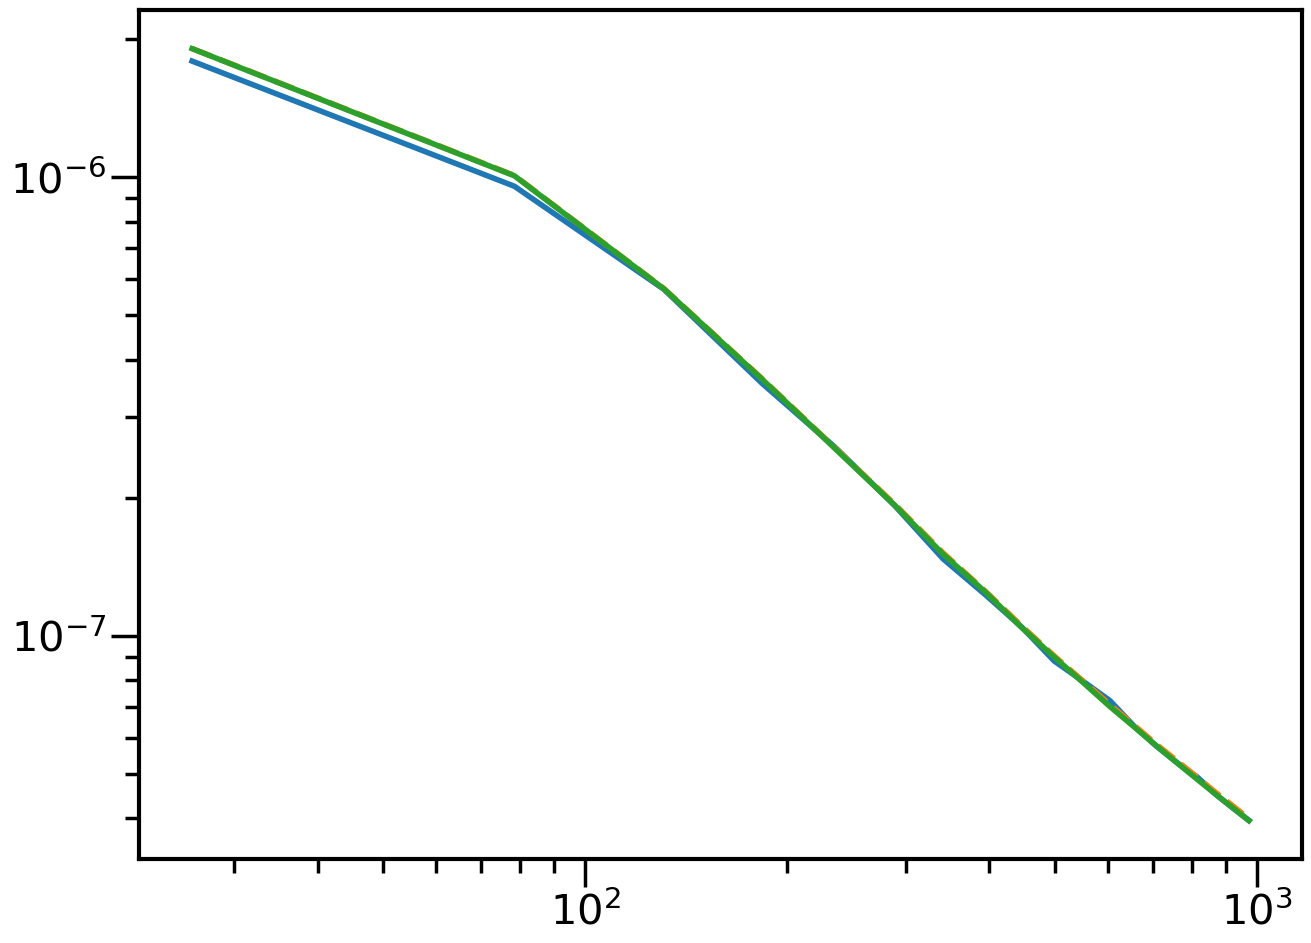

In [88]:
plot(lb,clg_jk_mean)
plot(lb,clg_sim0_mean,'--')
plot(lb,cl0['cl_b'][corr])
loglog()

[]

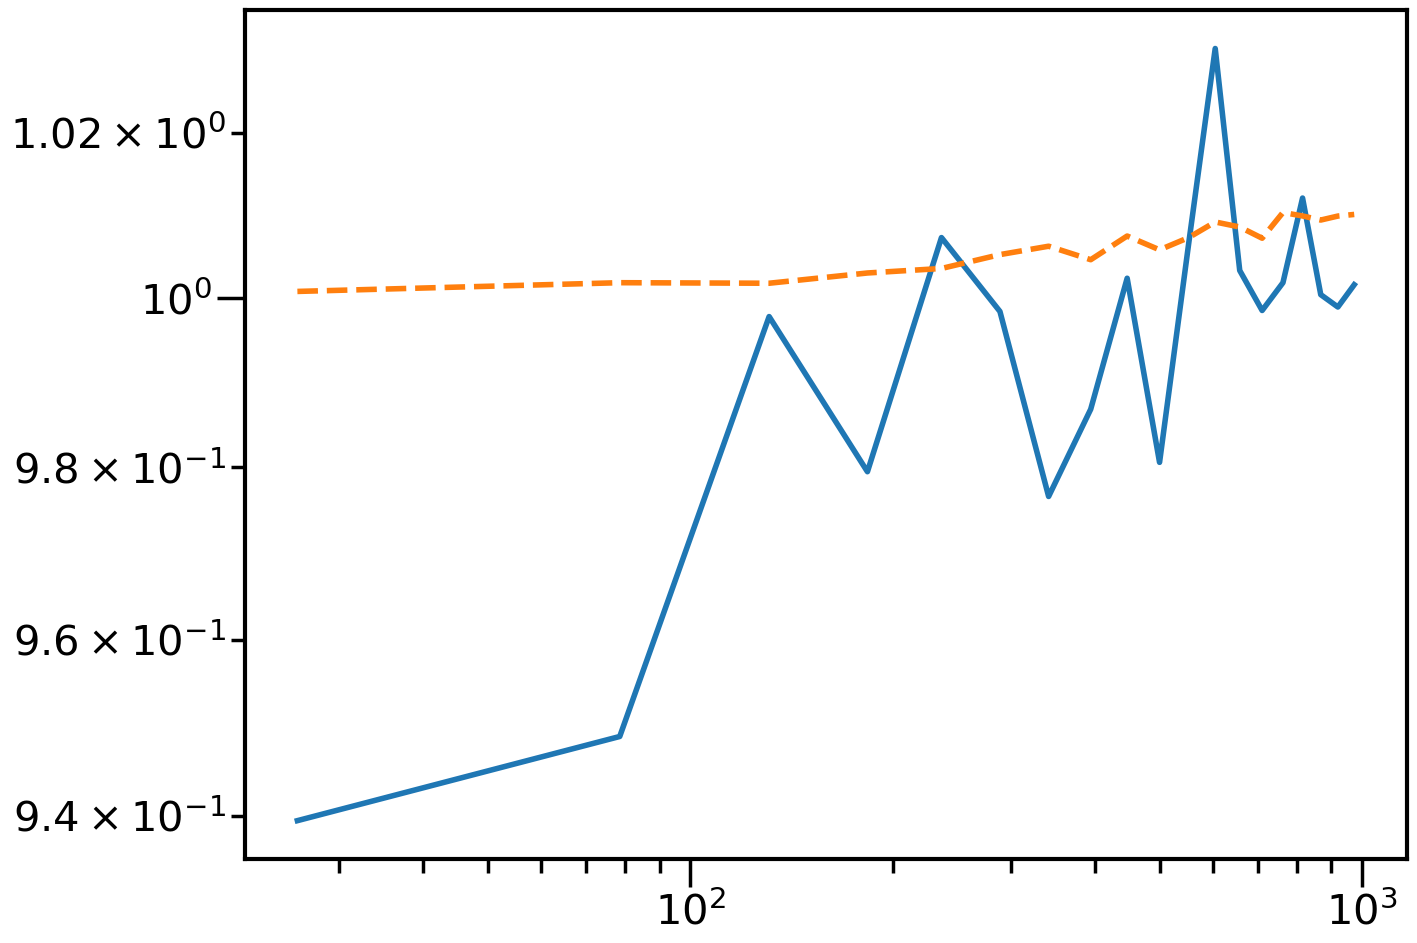

In [89]:
plot(lb,clg_jk_mean/cl0['cl_b'][corr])
plot(lb,clg_sim0_mean/cl0['cl_b'][corr],'--')
loglog()

[]

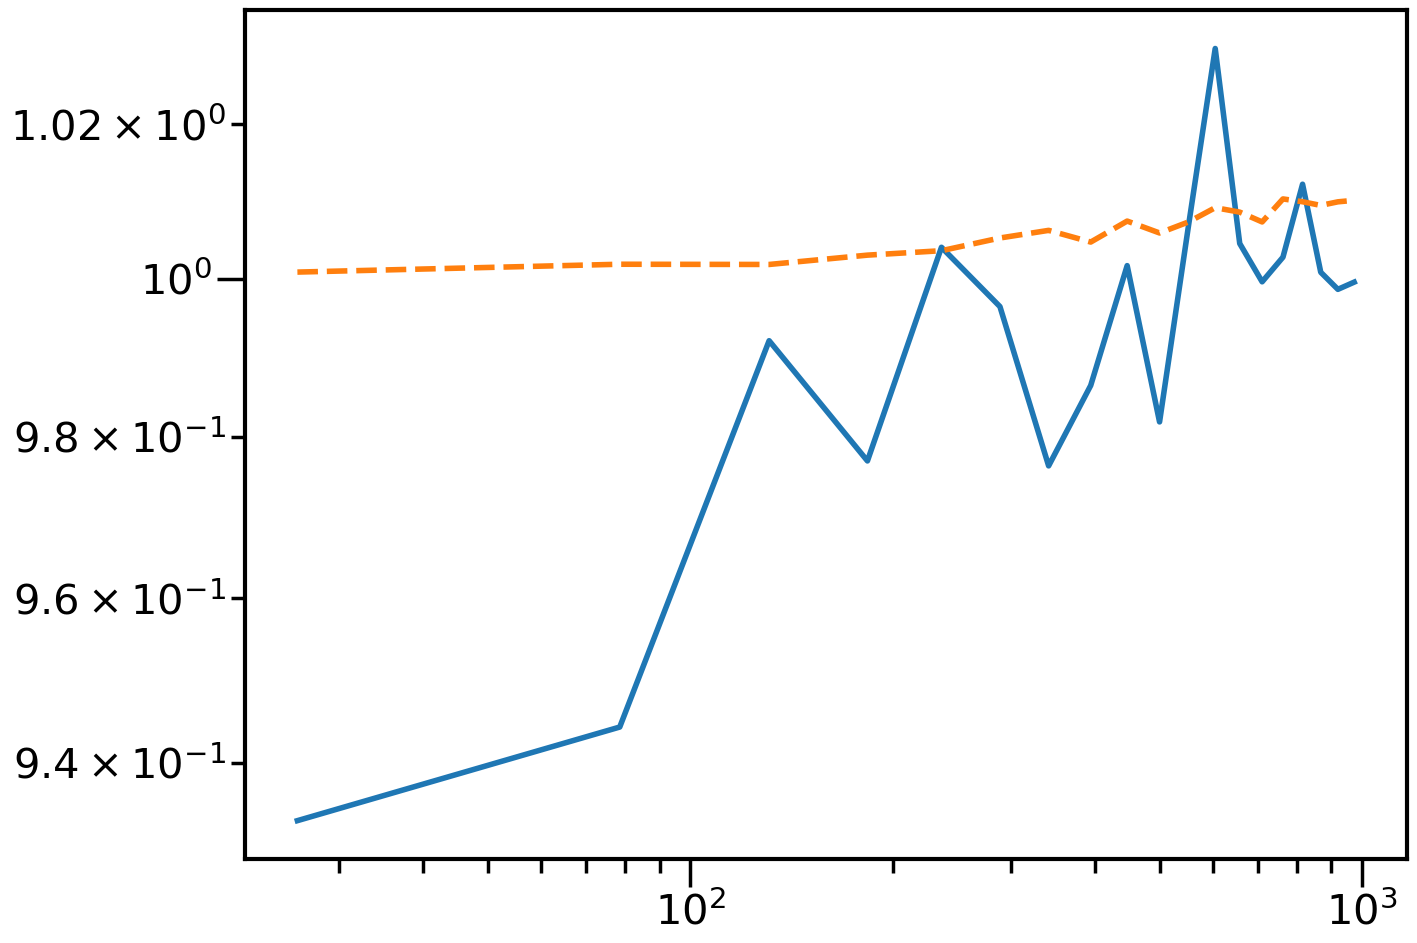

In [90]:
plot(lb,clp_jk_mean/cl0_win['cl_b'][corr])
plot(lb,clp_sim0_mean/cl0_win['cl_b'][corr],'--')
loglog()

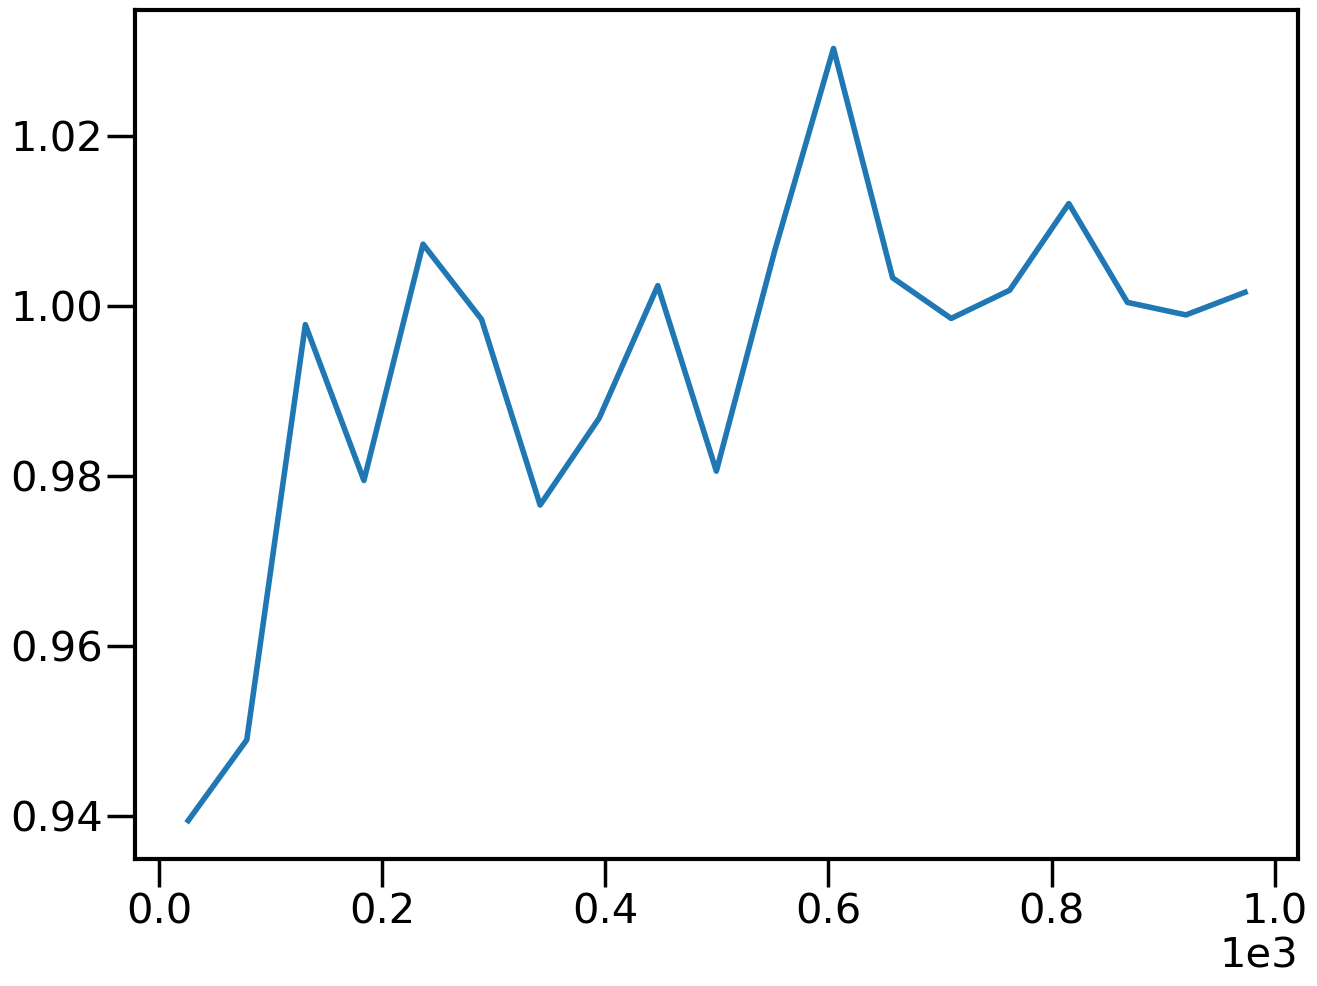

In [91]:
plot(lb,clg_jk_mean/cl0['cl_b'][corr])

[]

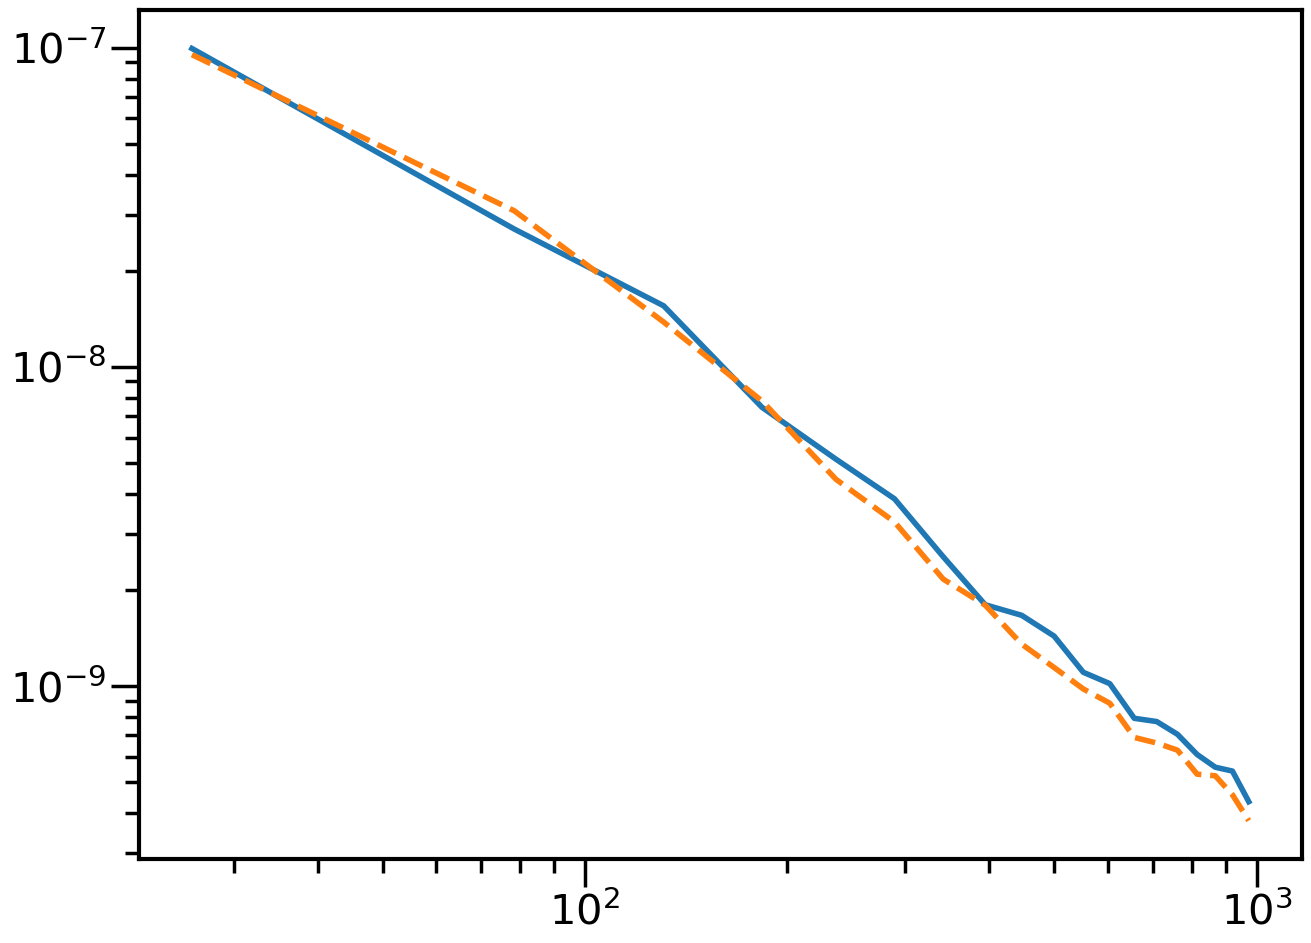

In [92]:
plot(lb,clg_jk_std)
plot(lb,clg_sim0_std,'--')
loglog()

[]

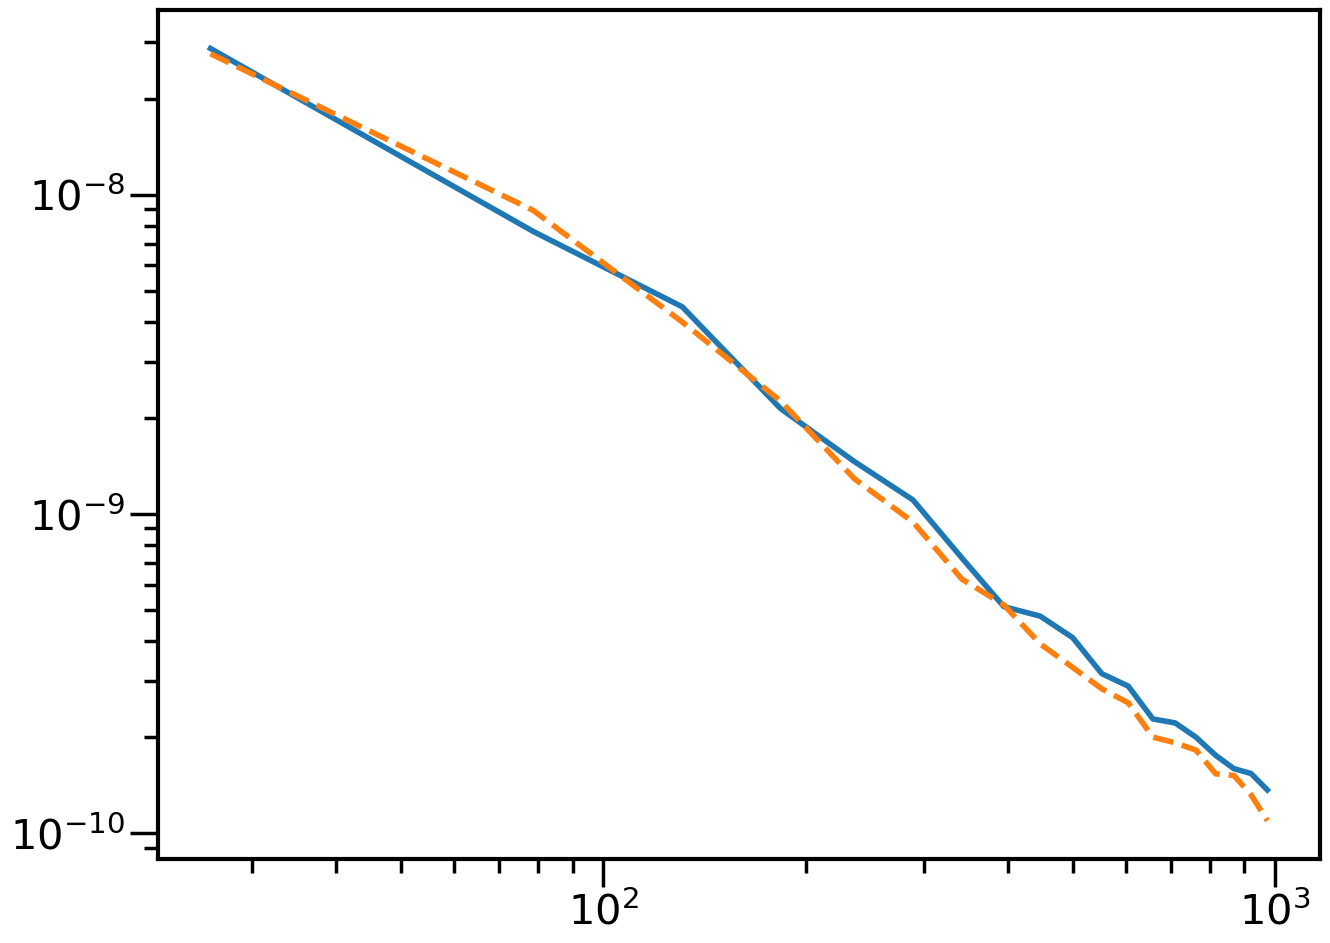

In [93]:
plot(lb,clp_jk_std)
plot(lb,clp_sim0_std,'--')
loglog()

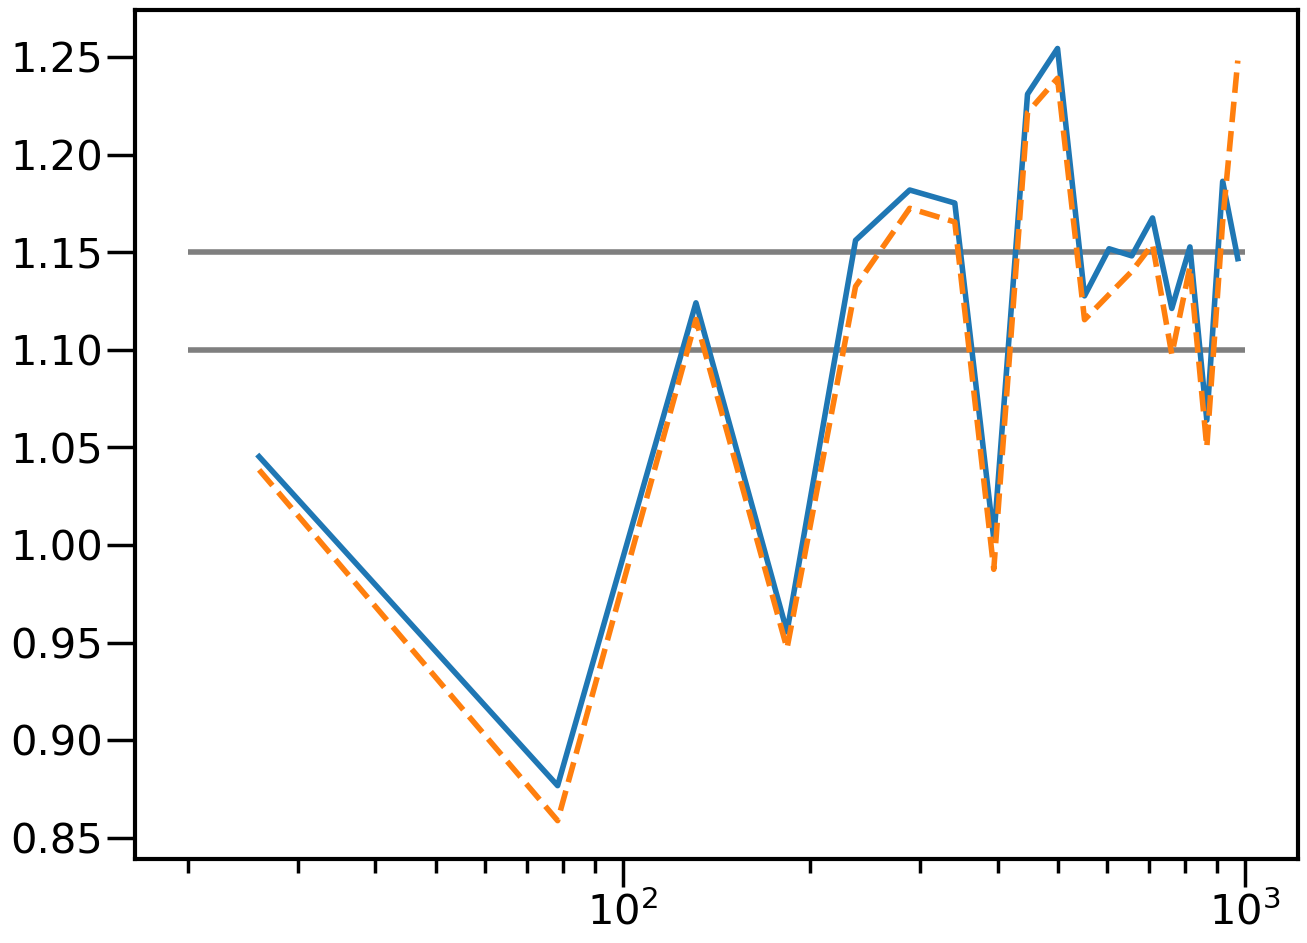

In [94]:
plot(lb,clg_jk_std/clg_sim0_std)
plot(lb,clp_jk_std/clp_sim0_std,'--')
hlines(1.1,20,1000,alpha=0.5)
hlines(1.15,20,1000,alpha=0.5)
xscale('log')

In [95]:
cc_jk=corr_matrix(clg_jk_cov)
cc_sim=corr_matrix(clg_sim0_cov)

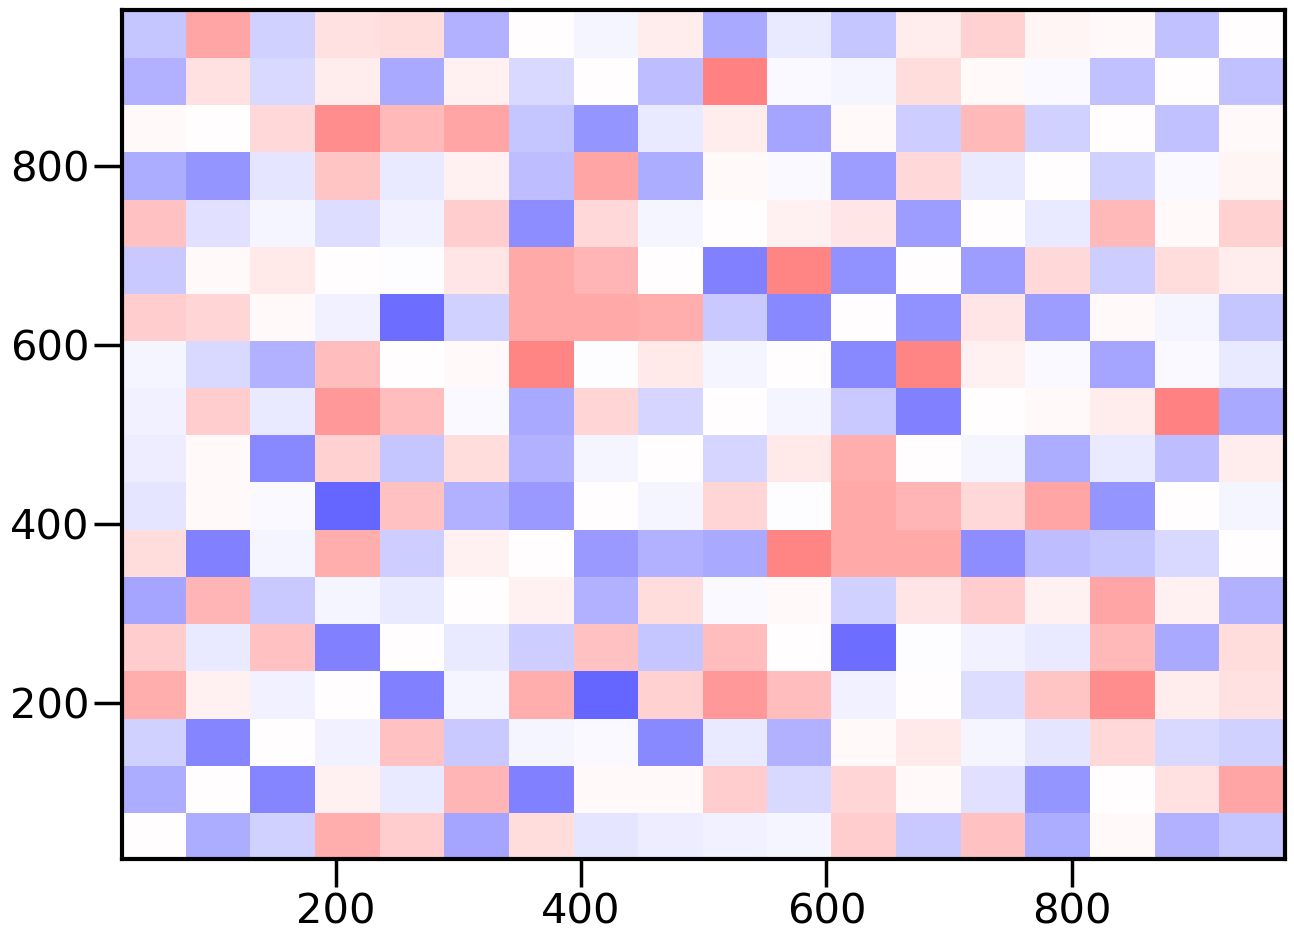

In [96]:
pcolor(lb,lb,cc_jk-cc_sim,vmin=-1,vmax=1,cmap='seismic')
# xscale('log')
# yscale('log')

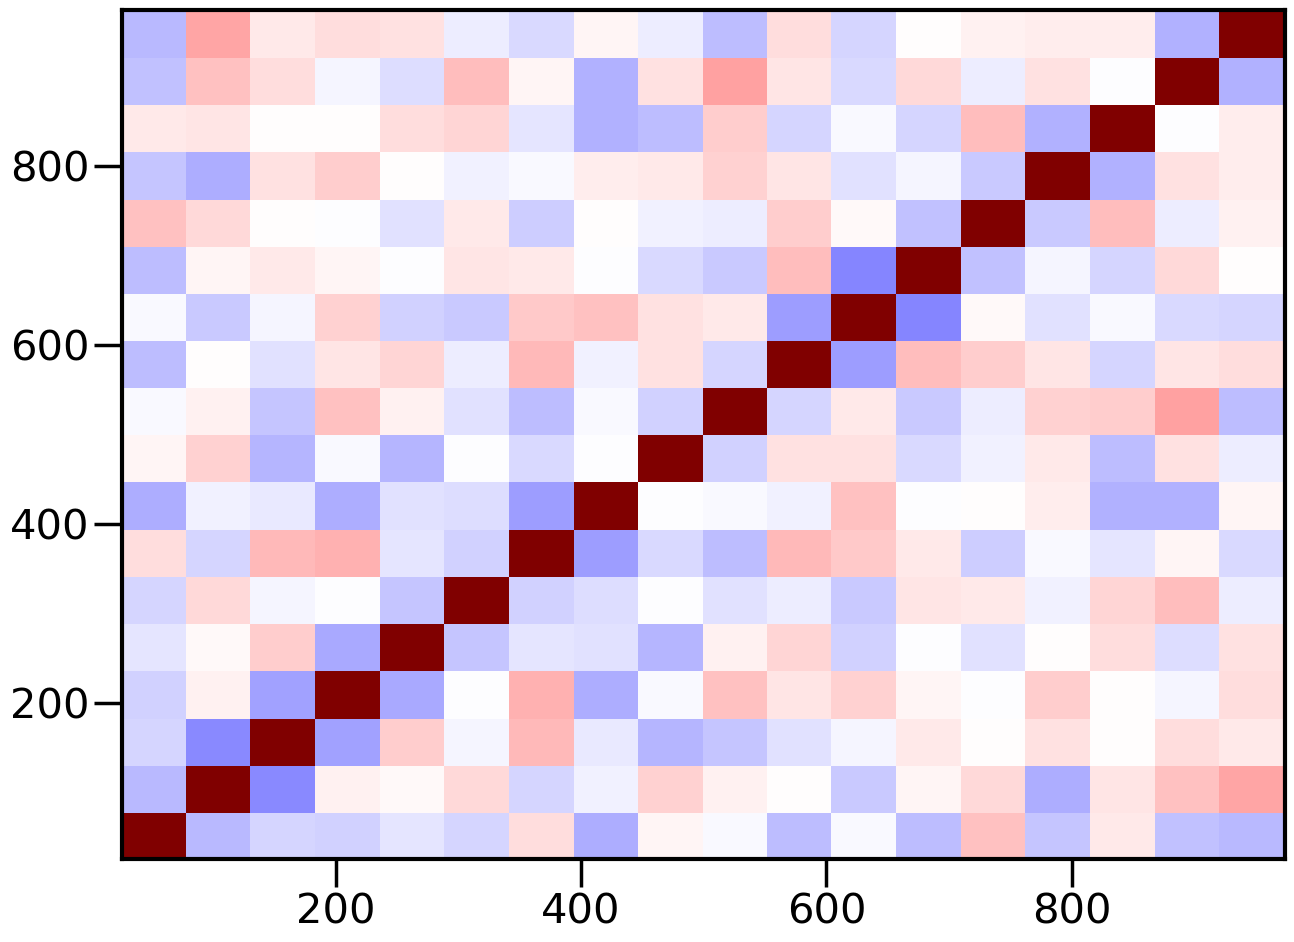

In [97]:
pcolor(lb,lb,cc_jk,vmin=-1,vmax=1,cmap='seismic')

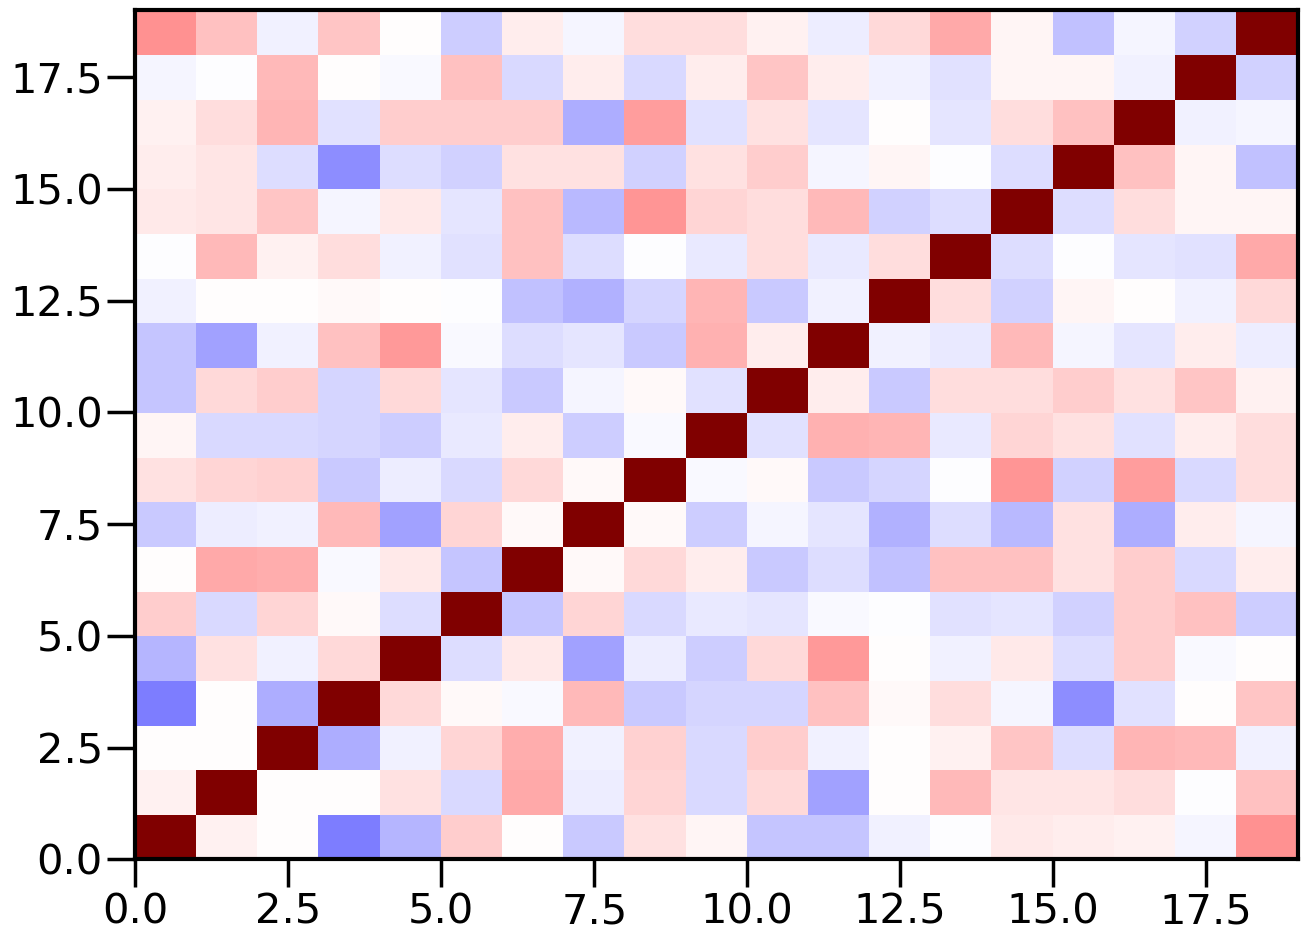

In [98]:
pcolor(cc_sim,vmin=-1,vmax=1,cmap='seismic')

In [99]:
def matrix_cut(mat=[],x=[]):
    m=mat[x]
    N=sum(x)
    m2=np.zeros((N,N))
    j=0
    for i in m:
        m2[j]=i[x]
        j=j+1
    return m2

def SN_cum(cov=[],lb=[],cl=[],diag=False,lmin=2,use_hartlap=False,nsim=1000):
    sni=np.zeros_like(lb)
    for i in np.arange(len(lb)):
        if lb[i]<lmin:
            continue
        x=lb<=lb[i]
        x*=lb>lmin
        cov2_cut=matrix_cut(mat=cov,x=x)
        if diag:
            cov2_cut=np.diag(np.diag(cov2_cut))
        cov2_cut_inv=np.linalg.inv(cov2_cut)
        
        cl_i=cl[x]
        SN2=cl_i@cov2_cut_inv@cl_i
        if use_hartlap:
            SN2*=(nsim-2-x.sum())/(nsim-1)
        sni[i]=SN2
    return sni

In [100]:
use_hartlap=True
sn={corr:{}}
sn[corr]['jk']=SN_cum(cov=clg_jk_cov,lb=lb,cl=clg_jk_mean,use_hartlap=use_hartlap,nsim=njk)
sn[corr]['sim']=SN_cum(cov=clg_sim0_cov,lb=lb,cl=clg_sim0_mean,use_hartlap=use_hartlap,nsim=njk)

sn[corr]['jk0']=SN_cum(cov=clg_jk_cov,lb=lb,cl=cl0['cl_b'][corr],use_hartlap=use_hartlap,nsim=njk)
sn[corr]['sim0']=SN_cum(cov=clg_sim0_cov,lb=lb,cl=cl0['cl_b'][corr],use_hartlap=use_hartlap,nsim=njk)

In [101]:
sn[corr]['jk_p']=SN_cum(cov=clp_jk_cov,lb=lb,cl=clp_jk_mean,use_hartlap=use_hartlap,nsim=njk)
sn[corr]['sim_p']=SN_cum(cov=clp_sim0_cov,lb=lb,cl=clp_sim0_mean,use_hartlap=use_hartlap,nsim=njk)

sn[corr]['jk_p0']=SN_cum(cov=clp_jk_cov,lb=lb,cl=cl0_win['cl_b'][corr],use_hartlap=use_hartlap,nsim=njk)
sn[corr]['sim_p0']=SN_cum(cov=clp_sim0_cov,lb=lb,cl=cl0_win['cl_b'][corr],use_hartlap=use_hartlap,nsim=njk)

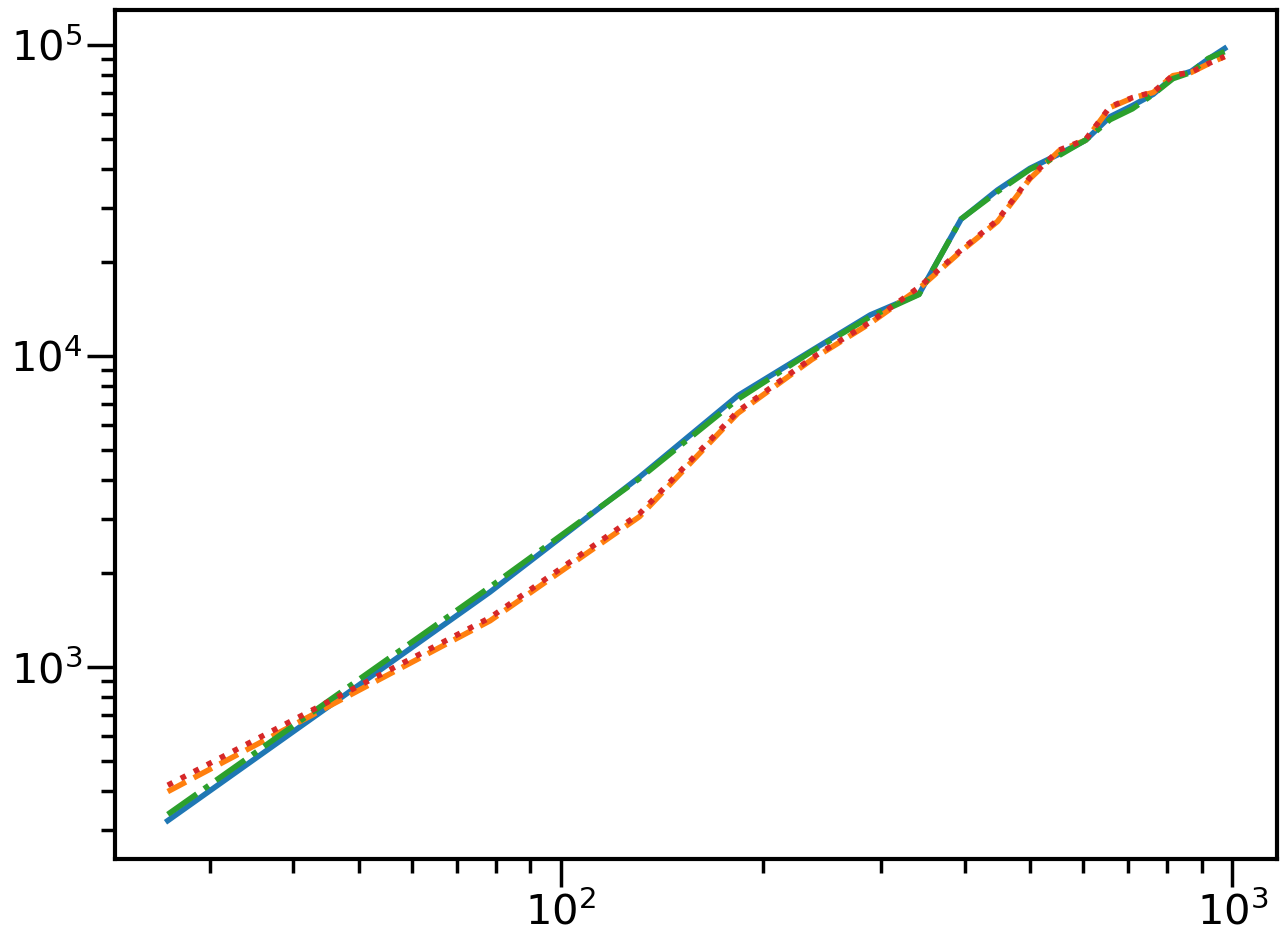

[]

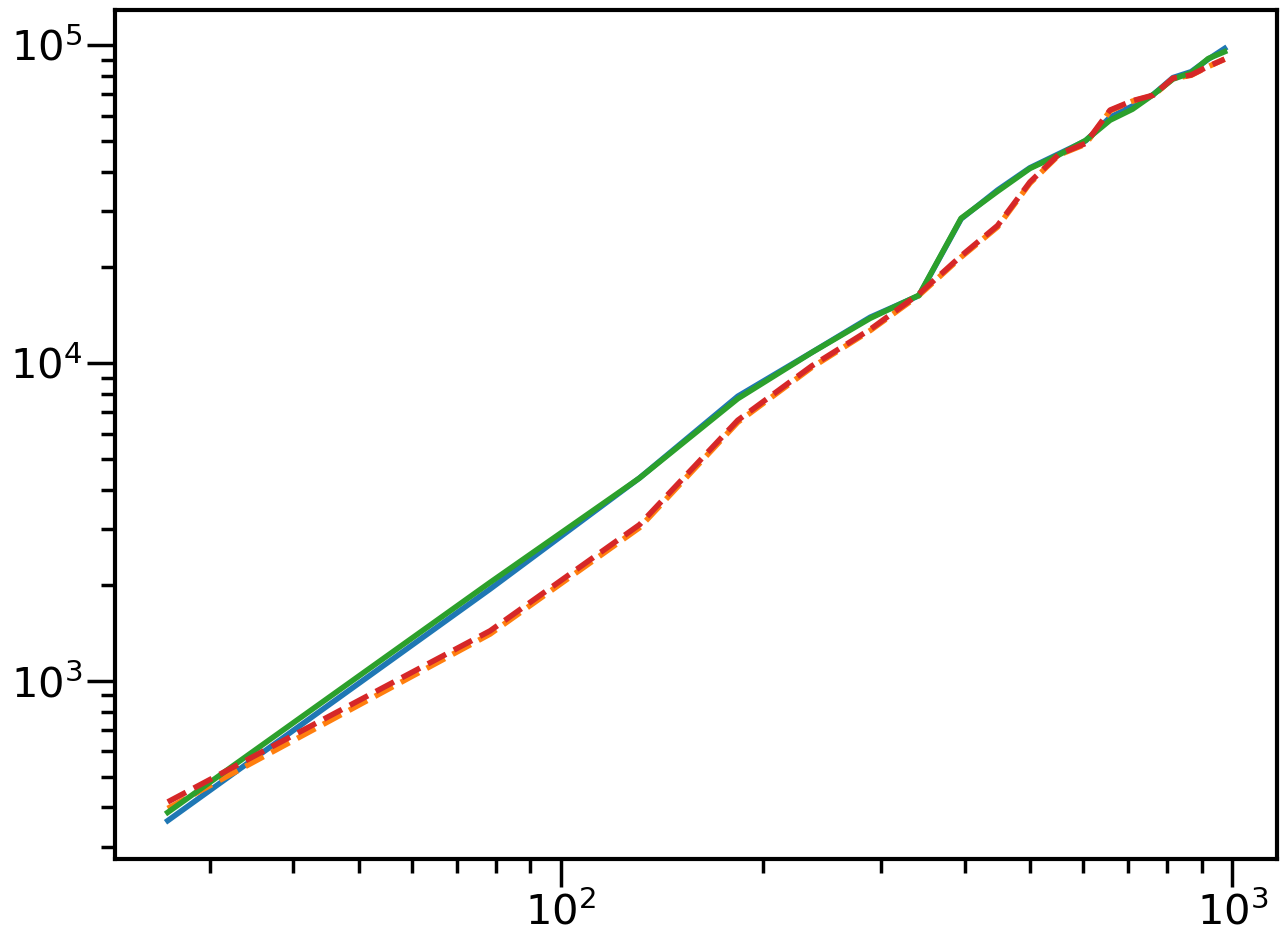

In [102]:
plot(lb,sn[corr]['jk'])
plot(lb,sn[corr]['sim'],'--')
plot(lb,sn[corr]['jk_p'],'-.')
plot(lb,sn[corr]['sim_p'],':')
loglog()
show()
plot(lb,sn[corr]['jk0'])
plot(lb,sn[corr]['sim0'],'--')
plot(lb,sn[corr]['jk_p0'])
plot(lb,sn[corr]['sim_p0'],'--')
loglog()

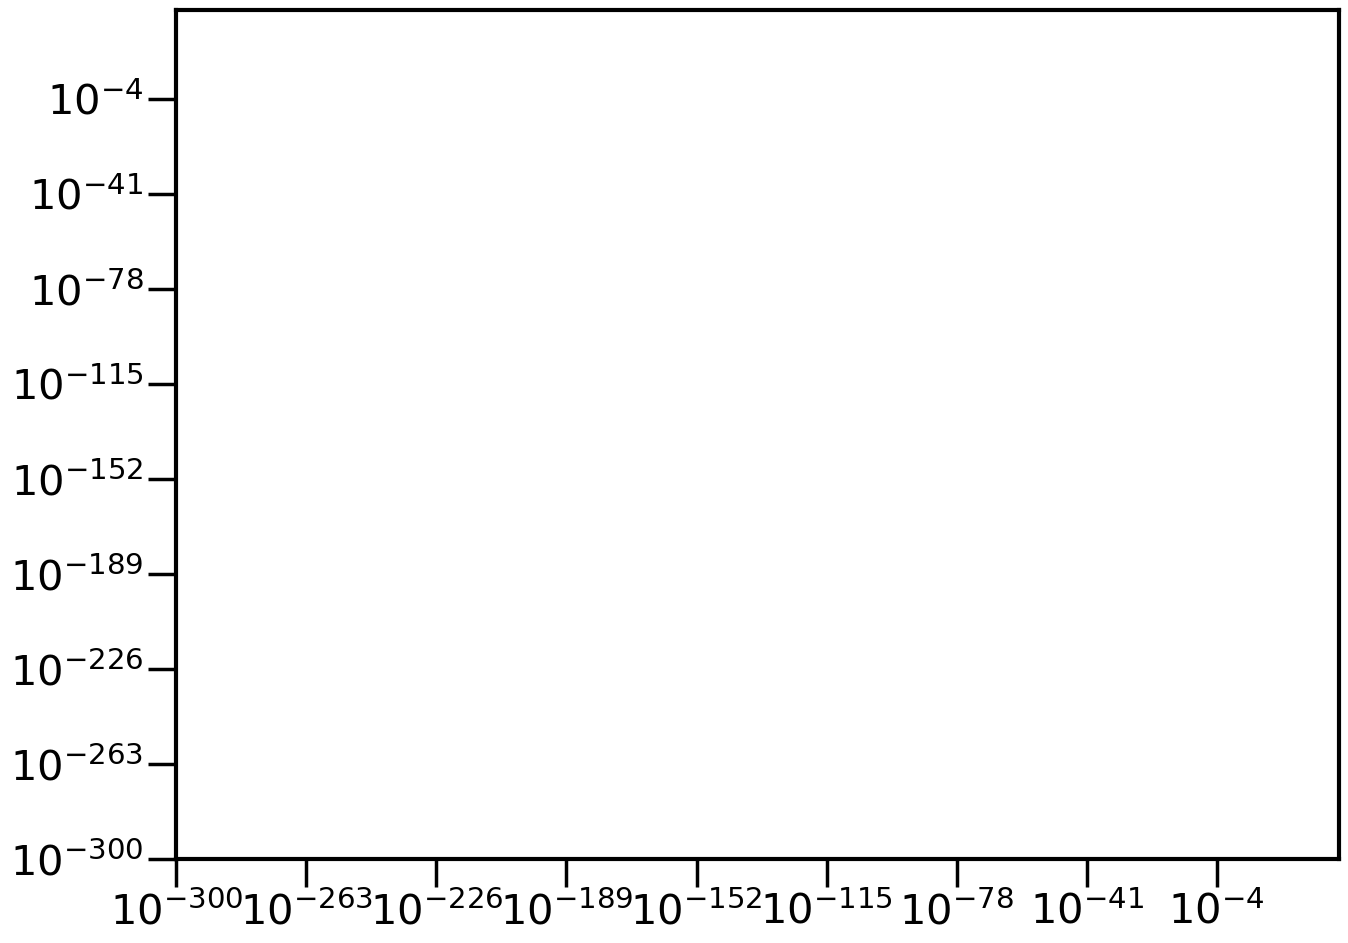

[]

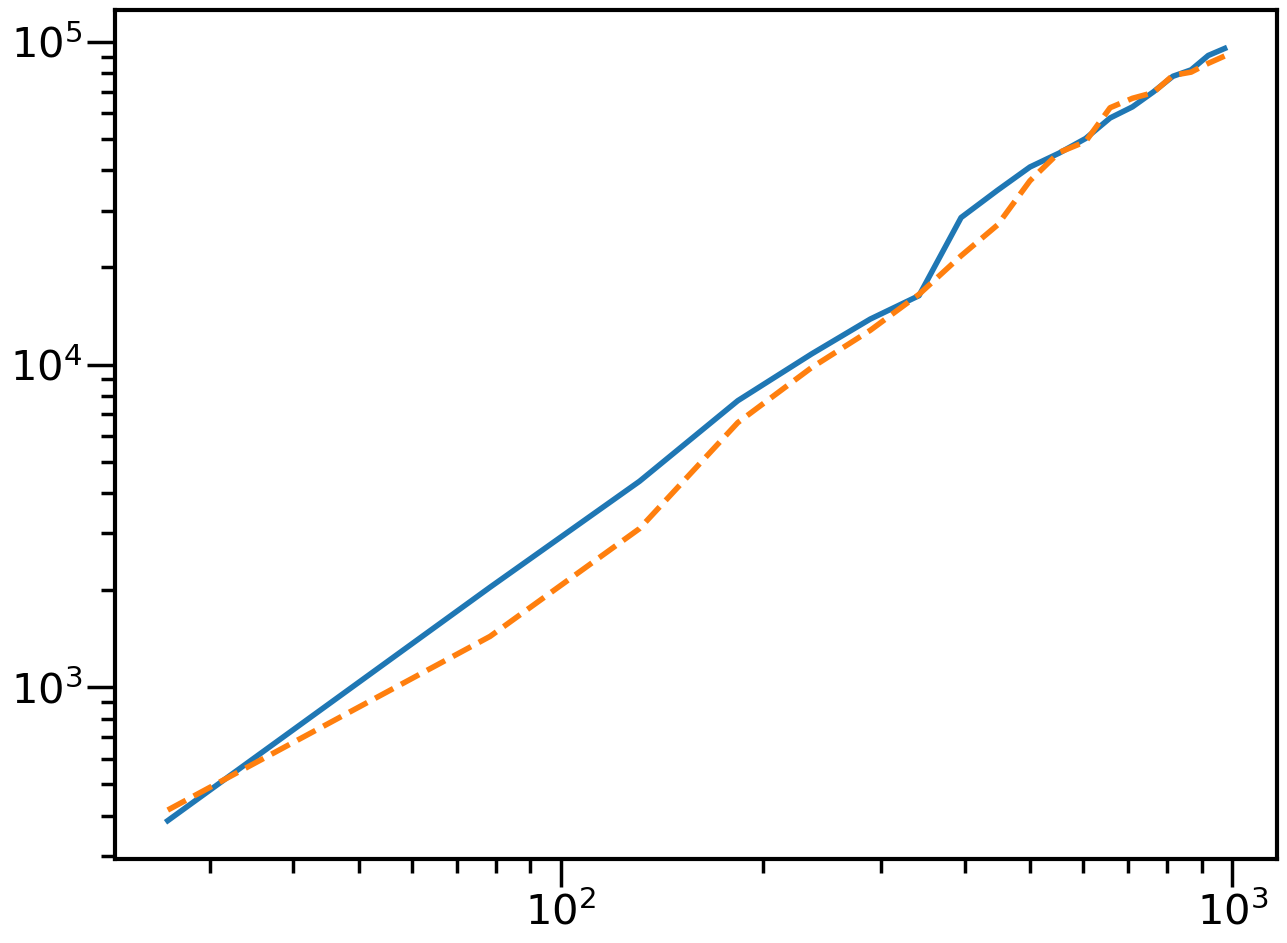

In [103]:
plot(lb,sn[corr]['jk_p0'])
plot(lb,sn[corr]['sim_p0'],'--')
loglog()

In [64]:
crash

NameError: name 'crash' is not defined

In [ ]:
plot(lb,clg_sim[0])
plot(lb,cl0['cl_b'][corr])

In [ ]:
top_stats = snapshot1.statistics('traceback')

In [ ]:
tracemalloc.get_traced_memory()

In [ ]:
stat = top_stats[0]
print("%s memory blocks: %.1f MiB" % (stat.count, stat.size / 1024**2))
for line in stat.traceback.format():
    print(line)

In [ ]:
dask.visualize(XI_W_L.Win.Win_cl)

In [ ]:
dask.visualize(XI_W_L.Win.Win_cov)

In [ ]:
crash

In [ ]:
clG['stack'].visualize()

In [ ]:
cl=clG['cl'][corr_ll][bi].compute()
pcl=clG['cl_b'][corr_ll][bi].compute()

In [ ]:
lb=0.5*(XI_W_L.l_bins[1:]+XI_W_L.l_bins[:-1])

In [ ]:
plot(XI_W_L.l,cl)
plot(lb,pcl)
loglog()

In [ ]:
A=np.int8(np.eye(1000))
X=np.float32(np.eye(1000))

In [ ]:
A

In [ ]:
B=A.astype('bool')

In [ ]:
%time x1=X*A
%time x2=X*B

In [ ]:
np.all(x1==x2)

In [ ]:
dask.visualize(clG['stack'])

In [ ]:
np.arange(1000,step=300)

In [ ]:
XI_W_L.Win.Win['cl'][corr_ll][bi]

In [ ]:
XI_W_L.Win.Win['cl'][corr_ll][bi]['M_B_noise']

In [ ]:
# M2=XI_W_L.Win.Win['cov'][corr_ll+corr_ll][bi+bi]['M1324'][2].compute()
try:
    M2n=XI_W_L.Win.Win['cl'][corr_ll][bi]['M_B'].compute()
except:
    M2n=XI_W_L.Win.Win['cl'][corr_ll][bi]['M_B']
XI_W_L.SN[corr_ll][:,0,0]@M2n

In [ ]:
bi=(0,0)
f=1#XI_W_L.l**2
# plot(XI_W_L.l,f*(XI_W_L.SN[corr_ll][:,0,0]@XI_W_L.Win.Win['cov'][corr_ll+corr_ll][bi+bi]['M1324'][2]))
plot(XI_W_L.l,f*(XI_W_L.SN[corr_ll][:,0,0]@M2n))
loglog()

In [ ]:
xx=np.random.uniform(0,1,size=(1000,100,3000,)).astype('float64')
xx2=xx.reshape(100,3000,1000)
xx3=xx2.astype('int8')
A=np.ones(1000)

In [ ]:
A2=np.int32(A)

In [ ]:
# %time clG=XI_W_L.cl_tomo()
%time clG_nw=XI_W_L_NW.cl_tomo()
#%time clH=XI_H.cl_tomo()

In [ ]:
clG_nw['stack'].visualize()

In [ ]:
%time cl_L_nw=clG_nw['stack'].compute()

In [ ]:
clG['cl'].keys()

In [ ]:
bi=(0,0)
corr=corr_ggl
cov_t=clG['cov'][corr+corr][(0,0,0,0)].compute()
cl_bt=clG['cl_b'][corr][(0,0)].compute()
cl_btnw=clG_nw['cl_b'][corr][(0,0)].compute()
cov_tnw=clG_nw['cov'][corr+corr][(0,0,0,0)].compute()

In [ ]:
nn='G1324'
plot(np.diag(cov_t[nn])/np.diag(cov_tnw[nn]))
loglog()

In [ ]:
plot(np.diag(cov_t['final_b'])/np.diag(cov_tnw['final_b']))
# loglog()

In [ ]:
crash

In [ ]:
plot(np.diag(cov_t['final_b']))
plot(cl_bt**2)
plot(np.diag(cov_tnw['final_b']),':')
plot(cl_btnw**2,':')
loglog()

In [ ]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(cov_t['final_b'])
corrW-=np.diag(np.diag(corrW))
pcolor(corrW,vmin=-.1,vmax=.1,cmap='seismic')
xticks([])
yticks([])
colorbar()
show()



In [ ]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(cl_L_nw['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
xticks([])
yticks([])
colorbar()
show()


In [ ]:
XI_W_L.Win.Win['cov'][(corr_ll+corr_ll)][bi+bi]['Om_w'],XI_W_L_NW.cov_utils.Om_W

In [ ]:
plot(XI_W_L.Win.Win['cov'][(corr_ll+corr_ll)][bi+bi]['mask_comb_cl'])
plot(XI_W_L_NW.cov_utils.Win)
yscale('log')

In [ ]:
XI_W_L.Win.Win['cov'][corr_ll+corr_ll][bi+bi]['mask_comb_cl']

In [ ]:
XI_W_L_NW.f_sky

In [ ]:
XI_W_L_NW.cov_utils.Win

In [ ]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(cl_L['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Wigner')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
linalg.cond(cl_L['cov']) #< 1/sys.float_info.epsilon

In [ ]:
N=np.linalg.norm(cl_L['cov'])
np.linalg.det(cl_L['cov']*5.e20)

In [ ]:
cov_inv=np.linalg.inv(cl_L['cov'])
cov_nw_inv=np.linalg.inv(cl_L_nw['cov'])
SN=cl_L['cl_b']@cov_inv@cl_L['cl_b']
SN_nw=cl_L_nw['cl_b']@cov_nw_inv@cl_L_nw['cl_b']
SN,SN_nw,SN/SN_nw

In [ ]:
%time xiWG_L=XI_W_L.xi_tomo()
%time xiWG_L_nw=XI_W_L_NW.xi_tomo()

In [ ]:
%time xiW_L=xiWG_L['stack'].compute()
%time xiW_L_nw=xiWG_L_nw['stack'].compute()

In [ ]:
XI_W_L.corrs

In [ ]:
XI_W_L.Win.Win.keys()

In [ ]:
f=1
xiW_L_nw_inv=np.linalg.inv(xiW_L_nw['cov']*f)
print ((np.dot(xiW_L_nw['xi'],np.dot(xiW_L_nw_inv,xiW_L_nw['xi']))))

cov_xiWL_inv=np.linalg.inv(xiW_L['cov']*f)
print ((np.dot(xiW_L['xi'],np.dot(cov_xiWL_inv,xiW_L['xi']))))

In [ ]:
pcolor(xiW_L_nw['cov']/xiW_L['cov'])
colorbar()

In [ ]:
pcolor(xiW_L_nw_inv/cov_xiWL_inv)
colorbar()

In [ ]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(cl_L['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('$C_\ell$')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(cl_L_nw['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('$C_\ell$-NW')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
R=np.diag(cl_L_nw['cov']/cl_L['cov'])
plot(R)

In [ ]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(xiW_L['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Wigner-W')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
cc=XI_W_L.cov_utils
corrNW=cc.corr_matrix(xiW_L_nw['cov'])
pcolor(corrNW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Wigner-NW')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
pcolor(corrW/corrNW-1,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Wigner')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
XI_W_L.cov_utils.gaussian_cov_norm_2D

In [ ]:
np.diag(xiW_L_nw['cov'])/np.diag(xiW_L['cov'])

In [ ]:
5.25/1.93

In [ ]:
x=np.array([1,0.5,0.1,0.3,0.7])
plot(x,[1,1.93,5.25,2.85,1.37],'bo')
plot(x,1./x,'ro')
yscale('log')
xscale('log')

In [ ]:
xiW_L_nw['cov']/xiW_L['cov']

In [ ]:
xiW_L_nw['xi']/xiW_L['xi']